ULA iter    0, min=-1.044e+06, max=2.388e+05 grad_norm=8.340e+07, sample_mean=3.079e-04, sample_std=4.221e-04
ULA iter   50, min=-6.319e+05, max=1.360e+05 grad_norm=5.199e+07, sample_mean=4.883e-02, sample_std=6.820e-02
ULA iter  100, min=-3.819e+05, max=7.553e+04 grad_norm=3.293e+07, sample_mean=7.819e-02, sample_std=1.113e-01
ULA iter  150, min=-2.452e+05, max=5.014e+04 grad_norm=2.132e+07, sample_mean=9.595e-02, sample_std=1.393e-01
ULA iter  200, min=-1.692e+05, max=4.380e+04 grad_norm=1.418e+07, sample_mean=1.067e-01, sample_std=1.578e-01
ULA iter  250, min=-1.247e+05, max=3.728e+04 grad_norm=9.736e+06, sample_mean=1.132e-01, sample_std=1.703e-01
ULA iter  300, min=-9.322e+04, max=3.031e+04 grad_norm=6.896e+06, sample_mean=1.171e-01, sample_std=1.789e-01
ULA iter  350, min=-7.011e+04, max=2.483e+04 grad_norm=5.022e+06, sample_mean=1.195e-01, sample_std=1.849e-01
ULA iter  400, min=-5.316e+04, max=2.112e+04 grad_norm=3.742e+06, sample_mean=1.210e-01, sample_std=1.892e-01
ULA iter  

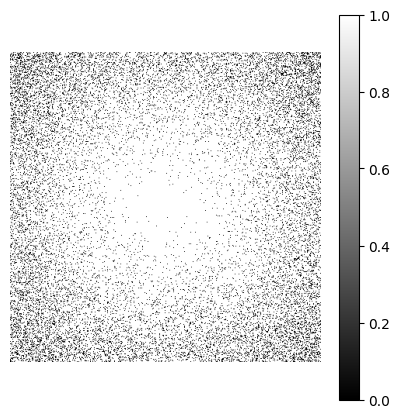

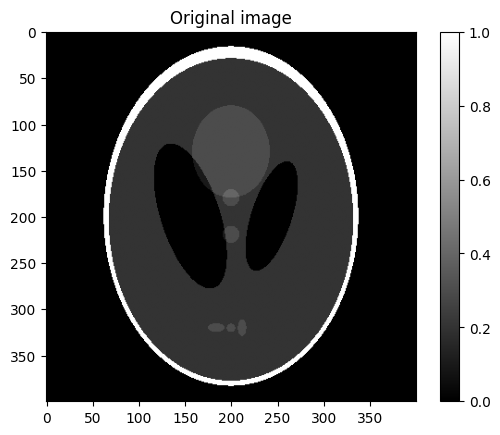

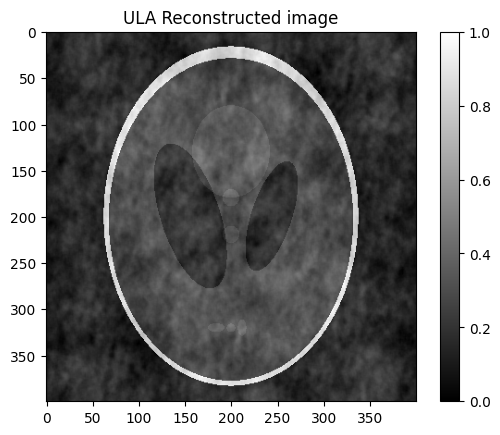

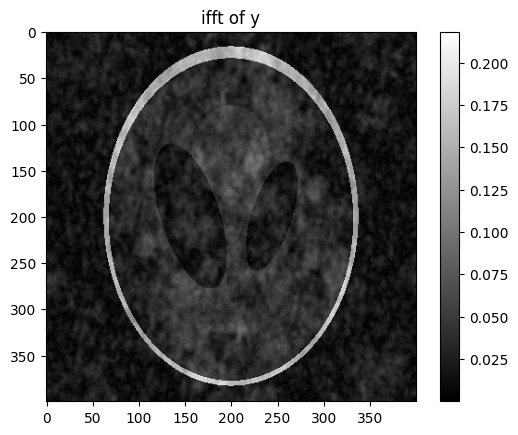

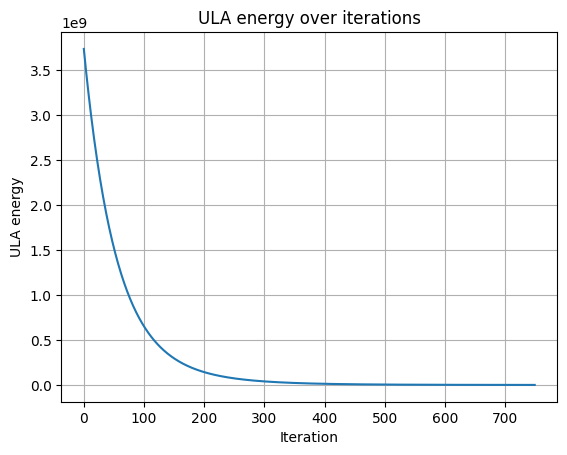

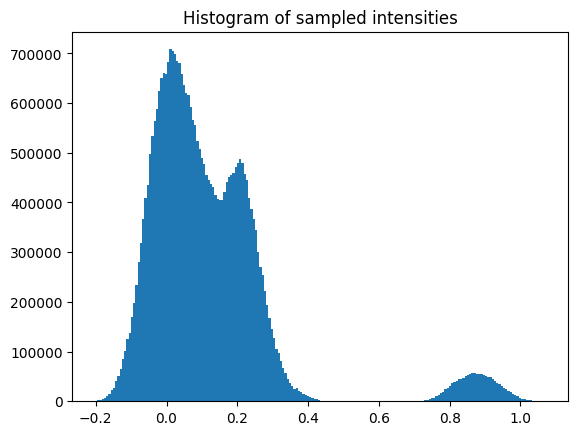

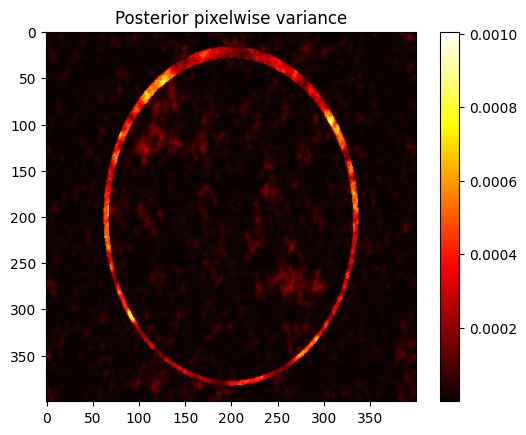

PSNR iFFT: 19.53 dB, NMSE iFFT: 0.1828, SSIM iFFT : 0.2775
None
PSNR ULA: 16.08 dB, NMSE ULA: 0.4053, SSIM ULA: 0.3272
None


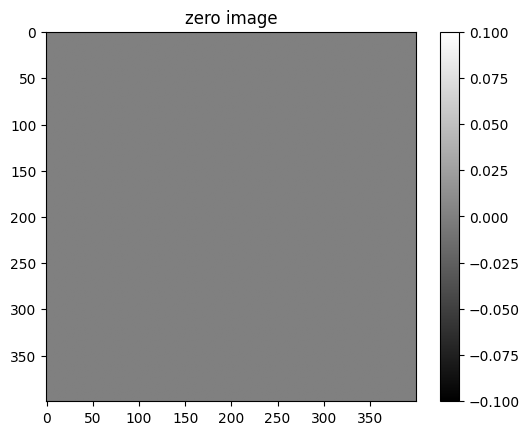

PSNR zeros: 12.15 dB, NMSE zeros: 1.0000, SSIM zeros: 0.5290
None


In [ ]:
import sys
import os

# Add the parent directory of MAP to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
    RadialMask
)
from utilities.metrics import ssim, nmse, psnr
from MMSE.mmse_ula import MMSEEstimatorULA


# load image
shepp_logan = ski.data.shepp_logan_phantom() # has values [0,1], no need to normalize

# create mask (in the F domain)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.5, 0.15, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask('gaussian', 1.15, seed=30).generate(shepp_logan.shape)
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, 2, 1, seed=30).get_mask()
radial_mask = RadialMask(shepp_logan.shape, 60, 0.12).generate()

# the 'actual' measurement
y = vd_mask * np.fft.fft2(shepp_logan, norm='ortho')

# init the ULA
ula_estimator = MMSEEstimatorULA(vd_mask, 0.001, 0.1, 5e-2, 1e-8, 350, 2, 200)

samples, energies = ula_estimator.ula_sampling(y)
ula_mmse = ula_estimator.compute_mmse_estimate(samples)

# plot mask
plt.figure(figsize=(5, 5))
plt.imshow(vd_mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.colorbar()
plt.axis('off')
plt.show()
#plt.subplot(1, 3, 1)
plt.title("Original image")
plt.imshow(shepp_logan, cmap="gray")
plt.colorbar()
plt.show()     
#plt.subplot(1, 3, 2)
plt.title("ULA Reconstructed image")
plt.imshow(np.abs(ula_mmse) / np.abs(ula_mmse.max()), cmap="gray")
plt.colorbar()
plt.show() 
#plt.subplot(1, 3, 3)
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
plt.colorbar()
plt.show()     

# # ULA
# ula energy
plt.plot(energies)
plt.title("ULA energy over iterations")
plt.xlabel("Iteration")
plt.ylabel("ULA energy")
plt.grid(True)
#plt.yscale('log')
plt.show()

samples_array = np.array(samples)
plt.hist(samples_array.ravel(), bins=200)
plt.title("Histogram of sampled intensities")
plt.show()

variance_map = np.var(samples_array, axis=0)
plt.imshow(variance_map, cmap='hot')
plt.colorbar()
plt.title("Posterior pixelwise variance")
plt.show()

# metrics
psnr_ifft = psnr(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
nmse_ifft = nmse(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
ssim_ifft = ssim(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
print(print(f"PSNR iFFT: {psnr_ifft:.2f} dB, NMSE iFFT: {nmse_ifft:.4f}, SSIM iFFT : {ssim_ifft:.4f}"))

psnr_ula = psnr(ula_mmse.real, shepp_logan) 
nmse_ula = nmse(ula_mmse.real, shepp_logan)
ssim_ula = ssim(ula_mmse.real, shepp_logan)
print(print(f"PSNR ULA: {psnr_ula:.2f} dB, NMSE ULA: {nmse_ula:.4f}, SSIM ULA: {ssim_ula:.4f}"))

# print(shepp_logan.min(), shepp_logan.max())
# print(np.abs(np.fft.ifft2(y, norm='ortho')).min(), np.abs(np.fft.ifft2(y, norm='ortho')).max())
# print(np.abs(map_reconstruct).min(), np.abs(map_reconstruct).max())